In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import datetime as dt
import time
import awkward as ak
import uproot
from tqdm import tqdm
from glob import glob
from scipy import stats as st
from scipy import signal
import numba as nb

import mplhep
mplhep.style.use(mplhep.style.ROOT)
plt.rcParams.update({'font.size': 23,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })


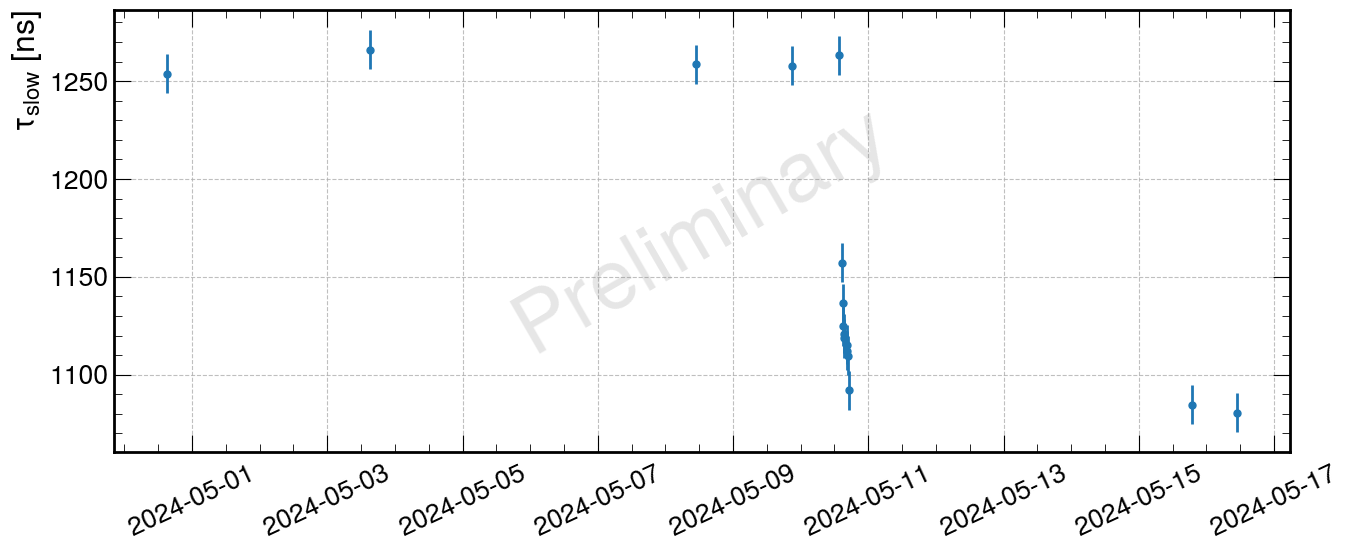

In [2]:
files = sorted(glob("./run0*/convolution_output.txt"))

dtp = np.dtype([
    ("time", np.uint64),
    ("A_f", np.float32),
    ("tau_f", np.float32 ),
    ("tau_s", np.float32 ),
    ("Efield", np.float32 ),
])

dict_Efield = {
26141:0,
26145:20,
26147:40,
26149:60,
26152:80,
26154:100,
26161:120,
26163:140,
26165:160,
26167:180,
}
data = np.zeros(len(files), dtype=dtp)
for i, file in enumerate(files):
    tmp = np.fromfile(file, sep=' ')

    data[i]['time'] = tmp[0]*16e-9
    data[i]['A_f'] = tmp[1]
    data[i]['tau_f'] = tmp[2]
    data[i]['tau_s'] = tmp[3]
    data[i]['Efield'] = -100

    for run, ef in dict_Efield.items():
        if f'run0{run}' in file:
            data[i]['Efield'] = ef
    
def preliminary(ax, x=0.5, y=0.5):
    ax.text(x, y, 'Preliminary', transform=ax.transAxes,
            fontsize=60, color='gray', alpha=0.2,
            ha='center', va='center', rotation=30)

plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax = plt.gca()
xfmt = mdate.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)
    
dates=[dt.datetime.fromtimestamp(ts) for ts in data['time']]
plt.errorbar(dates, data["tau_s"], yerr=10, fmt='.', linewidth=2, markersize=10)
plt.ylabel(r'$\tau_{slow}$ [ns]')
preliminary(ax)
plt.savefig('tau_vs_time.png', dpi=200)
# plt.errorbar(dates, 1-data["A_f"], yerr=0.002, fmt='+', )
# plt.ylabel(r'Slow component fraction')
# # print(data["tau_s"])

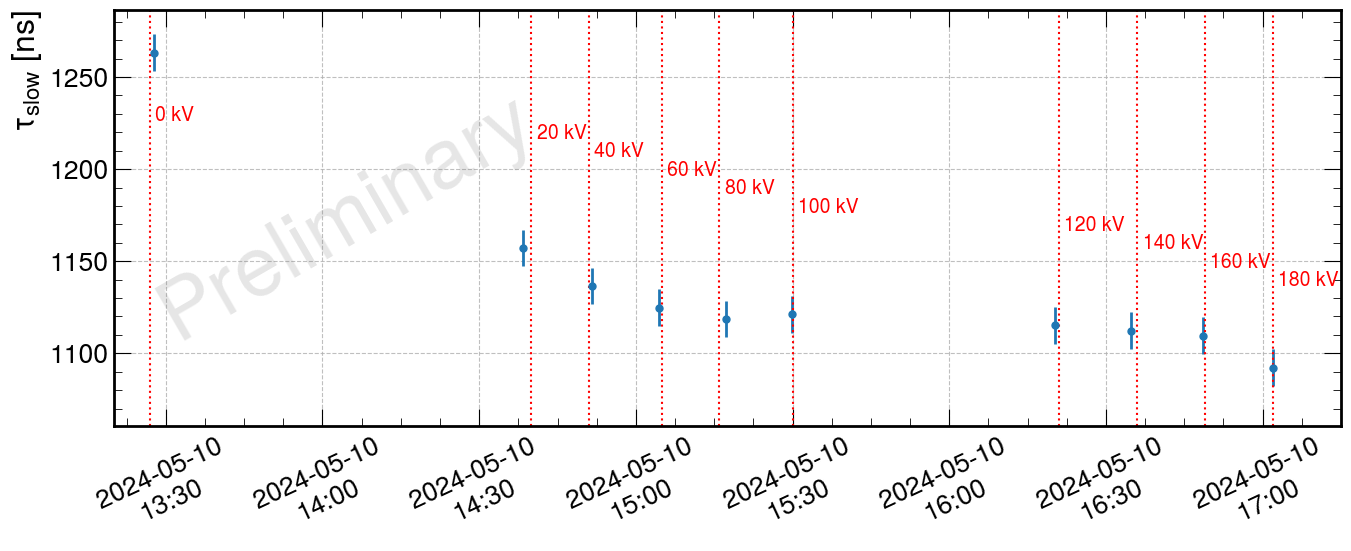

In [3]:

plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax = plt.gca()
xfmt = mdate.DateFormatter('%Y-%m-%d\n%H:%M')
ax.xaxis.set_major_formatter(xfmt)
timeflags ={
"2024-05-10T13:27": "0 kV",
"2024-05-10T14:40": "20 kV",
"2024-05-10T14:51": "40 kV",
"2024-05-10T15:05": "60 kV",
"2024-05-10T15:16": "80 kV",
"2024-05-10T15:30": "100 kV",
"2024-05-10T16:21": "120 kV",
"2024-05-10T16:36": "140 kV",
"2024-05-10T16:49": "160 kV",
"2024-05-10T17:02": "180 kV",
}


vlines = [ dt.datetime.fromisoformat(d) for d in timeflags.keys() ]
    
dates=[dt.datetime.fromtimestamp(ts) for ts in data['time']]
plt.errorbar(dates, data["tau_s"], yerr=10, fmt='.', linewidth=2, markersize=10)
plt.ylabel(r'$\tau_{slow}$ [ns]')
# plt.errorbar(dates, 1-data["A_f"], yerr=0.002, fmt='+', )
# plt.ylabel(r'Slow component fraction')
plt.xlim(dt.datetime.fromisoformat('2024-05-10T13:20'), dt.datetime.fromisoformat('2024-05-10T17:15'))
for i, (line, tag) in enumerate(zip(vlines, timeflags.values())):
    plt.axvline(line, linestyle=':', color='r')
    plt.text(line+dt.timedelta(minutes=1), y=ax.get_ylim()[1]-60-i*10,s=tag, fontsize=14, color='r')
    # plt.text(line+dt.timedelta(minutes=1), y=ax.get_ylim()[1]-0.01-i*0.005,s=tag, fontsize=14, color='r')
ax.get_ylim()
preliminary(ax,0.19)
plt.savefig('tau_vs_time_with_field.png', dpi=200)

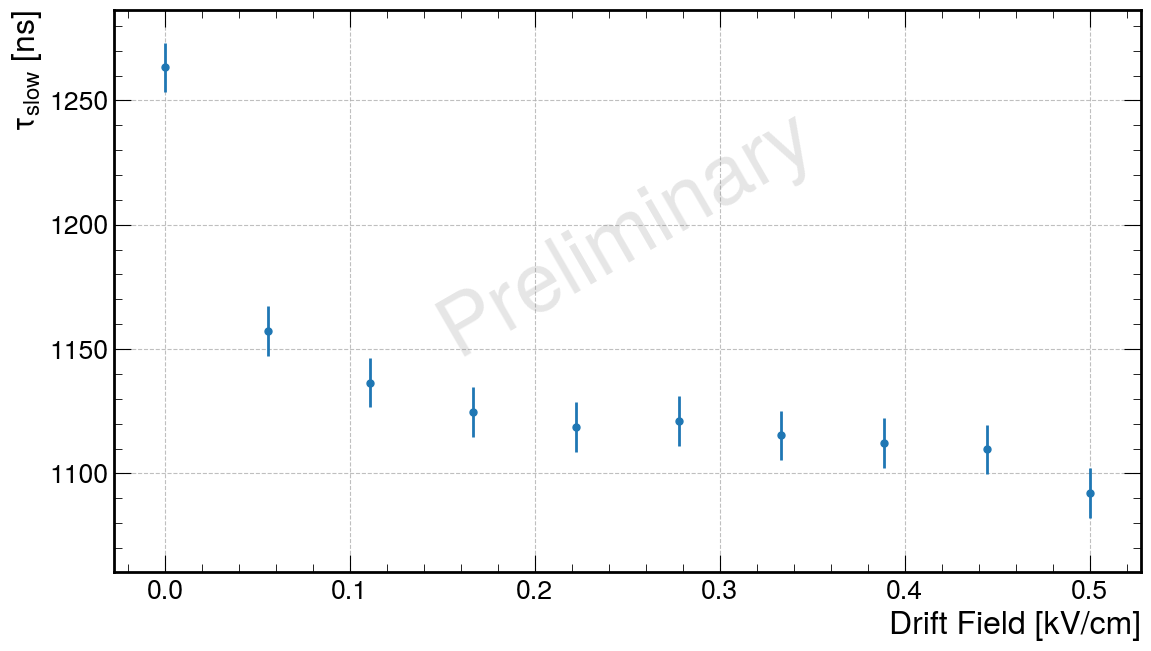

In [4]:
plt.figure(figsize=(12,7))
plt.errorbar(data['Efield']/360, data['tau_s'], 10, fmt='.', linewidth=2, markersize=10)
plt.ylabel(r'$\tau_{slow}$ [ns]')
plt.xlabel(r'Drift Field [kV/cm]')
plt.xlim(-10/360,190/360)

preliminary(plt.gca(),0.5,0.6)
plt.savefig('tau_vs_efield.png', dpi=200)

In [64]:
files_plot_resuls = sorted(glob("./run*/conv_fit.png"))
nfiles:int = len(files_plot_resuls)
print(files_plot_resuls)

['./run025171/conv_fit.png', './run025474/conv_fit.png', './run026084/conv_fit.png', './run026116/conv_fit.png', './run026141/conv_fit.png', './run026145/conv_fit.png', './run026147/conv_fit.png', './run026149/conv_fit.png', './run026152/conv_fit.png', './run026154/conv_fit.png', './run026161/conv_fit.png', './run026163/conv_fit.png', './run026165/conv_fit.png', './run026167/conv_fit.png', './run026254/conv_fit.png', './run026265/conv_fit.png']


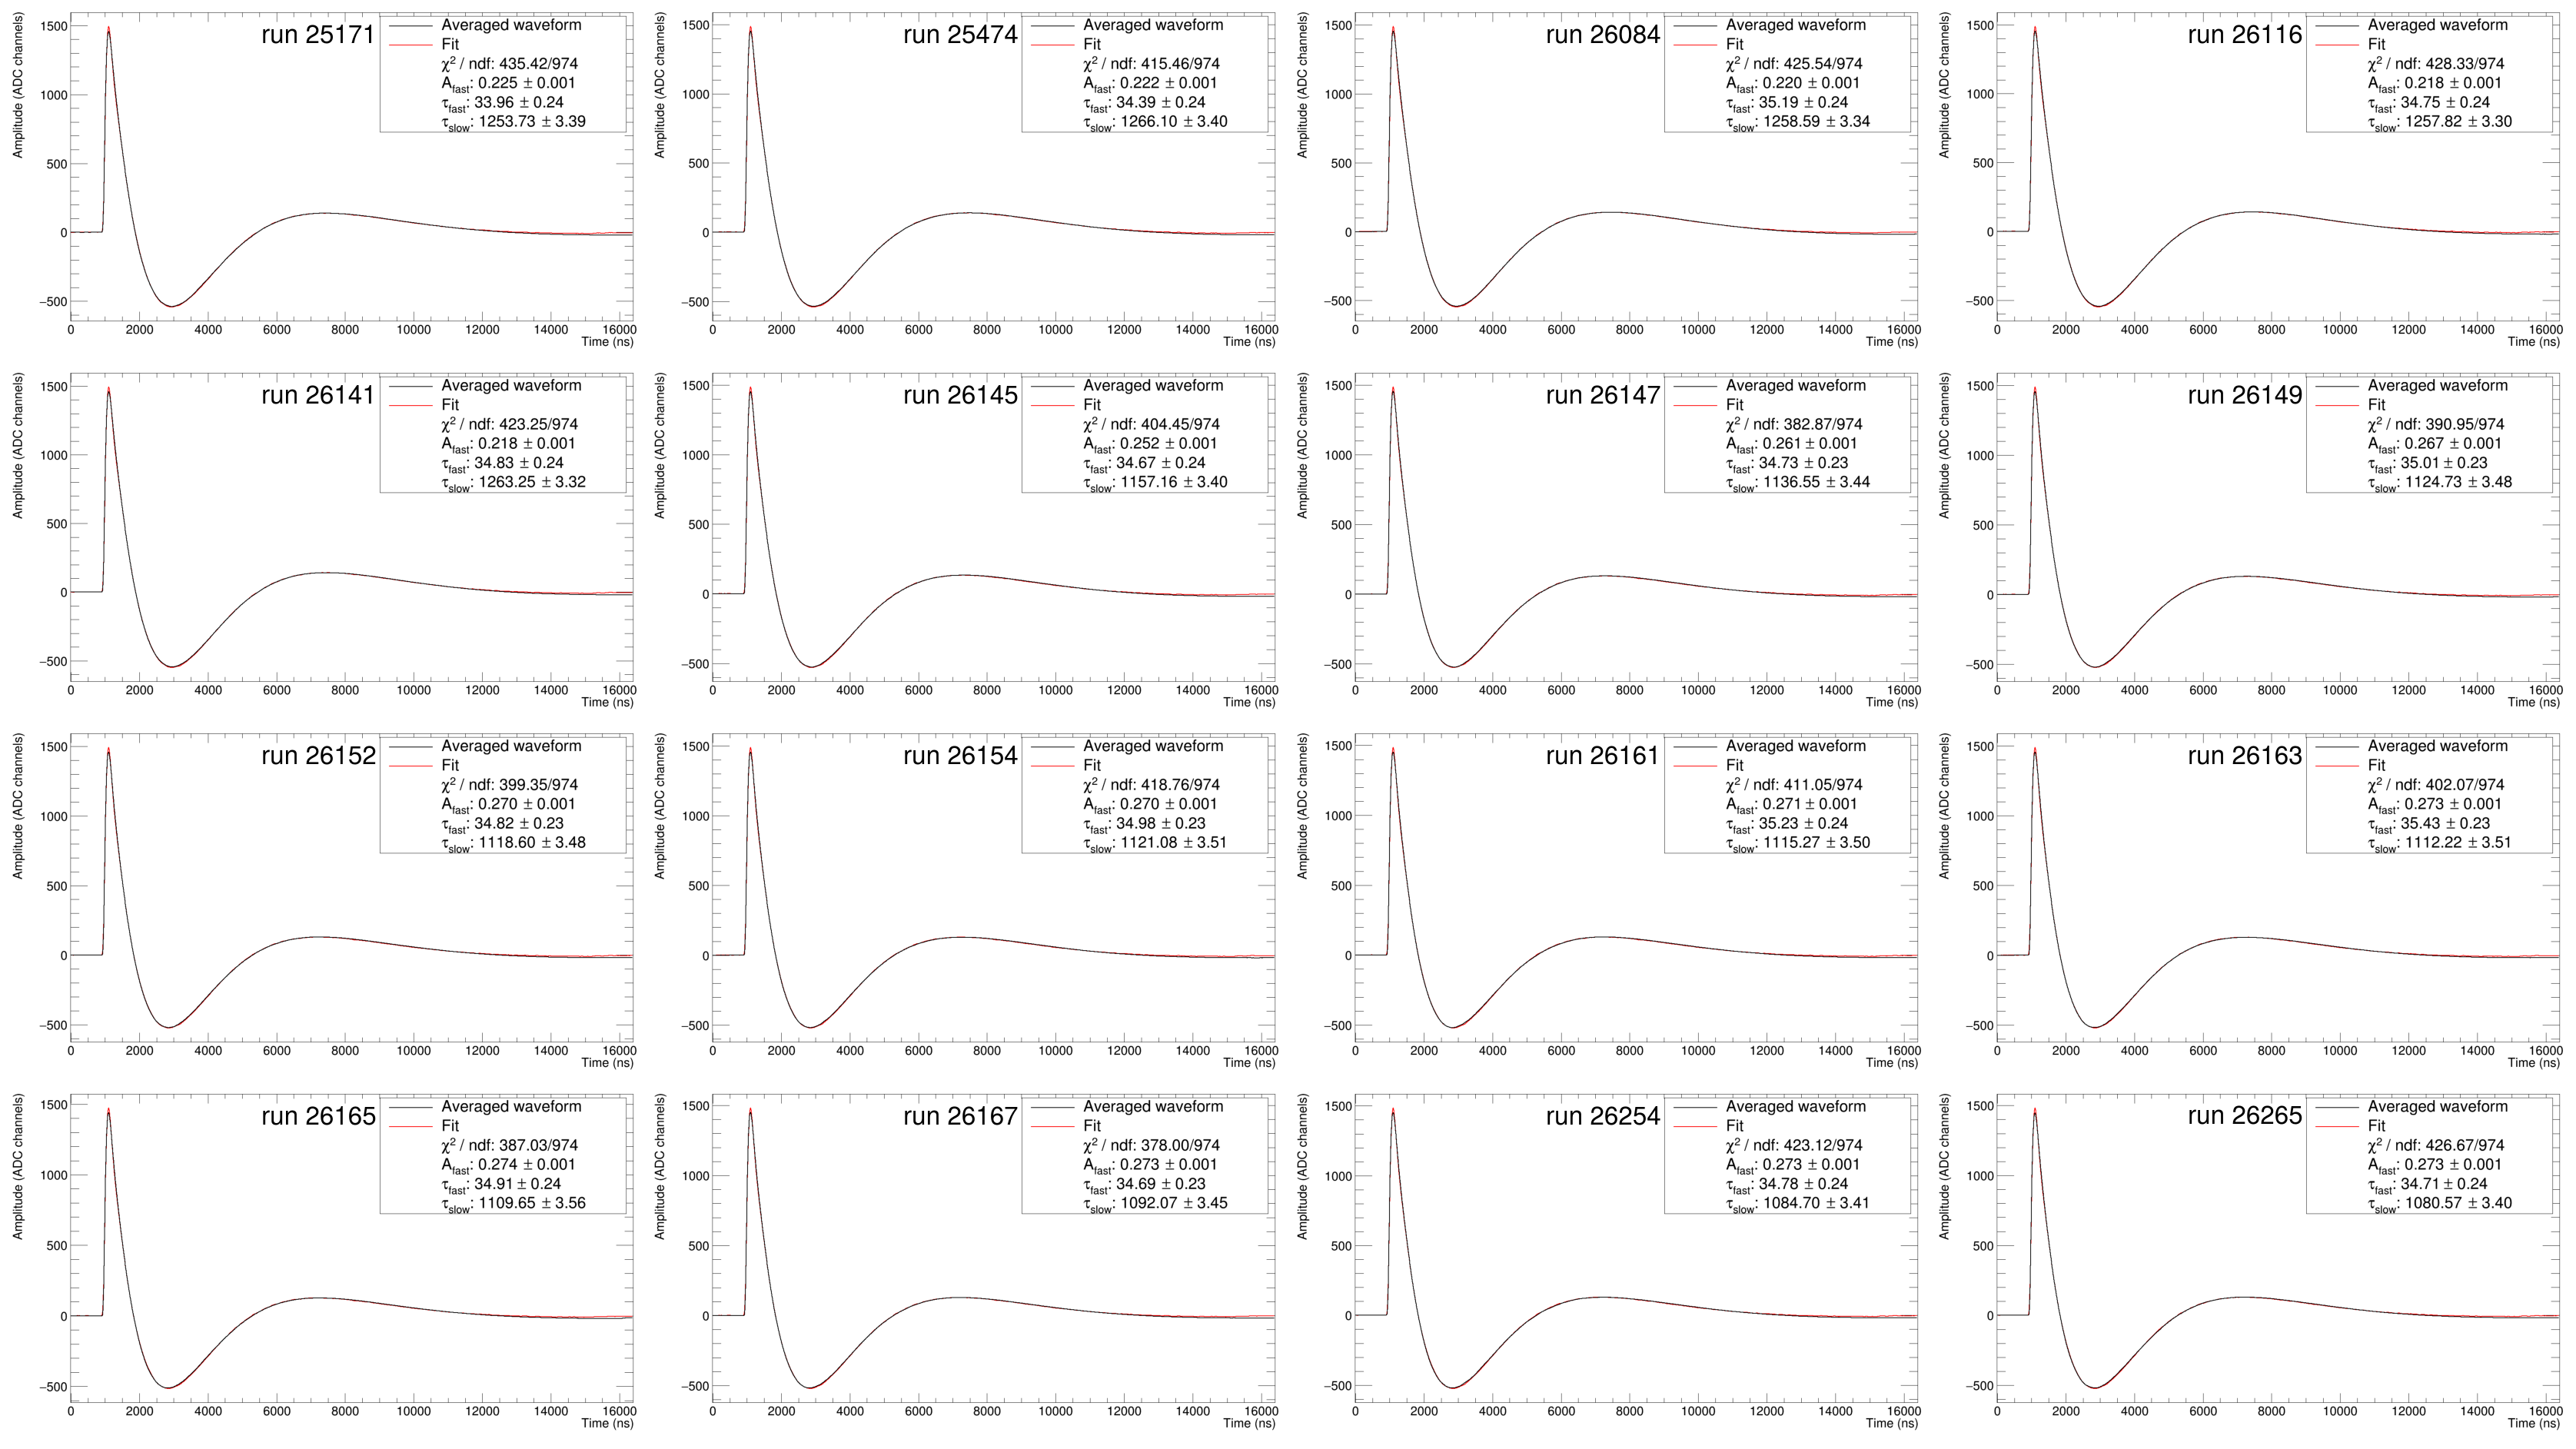

/tmp/ipykernel_3745434/1503176438.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('all_results.pdf', dpi=300, bbox_inches='tight')


In [78]:
from mpl_toolkits.axes_grid1 import ImageGrid
import re

fig = plt.figure(figsize=(34, 34.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of Axes
                 axes_pad=0.1,  # pad between Axes in inch.
                 )

for ax, im in zip(grid, files_plot_resuls):
    ax:plt.Axes
    result = plt.imread(im)
    result = result[90:, 20:1750,:]
    p = re.compile('./run0(.+)/conv_')
    m = p.match(im)
    r = f"run {m.group(1)}"
    ax.imshow(result)
    ax.text(0.4,0.9,r, transform=ax.transAxes, fontsize=24)
    ax.axis('off')

plt.show()
fig.savefig('all_results.pdf', dpi=300, bbox_inches='tight')
